In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

In [ ]:

!unzip -j -n /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/


In [4]:
data_path = '/content/train.txt'

In [5]:
import os

In [6]:
def frame_the_data(data_path):
  with open(data_path ,'r') as f:
    input_lines = f.readlines()

  abstract_lines = ""
  abstract_samples = []


  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  return abstract_samples



In [7]:
train_data=frame_the_data('/content/train.txt')
test_data=frame_the_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt")


In [ ]:
train_samples

In [ ]:
test_samples

In [11]:
train_statments= train_samples['text'].to_list()
train_labels= train_samples['target'].to_list()

test_statments= test_samples['text'].to_list()
test_labels= test_samples['target'].to_list()


In [ ]:
train_statments[0]

In [ ]:
len(train_statments),len(train_labels),len(test_statments),len(test_labels)

In [ ]:
train_statments_words_count=[len(word)for word in train_statments]
train_statments_words_count

In [14]:
import matplotlib.pyplot as plt

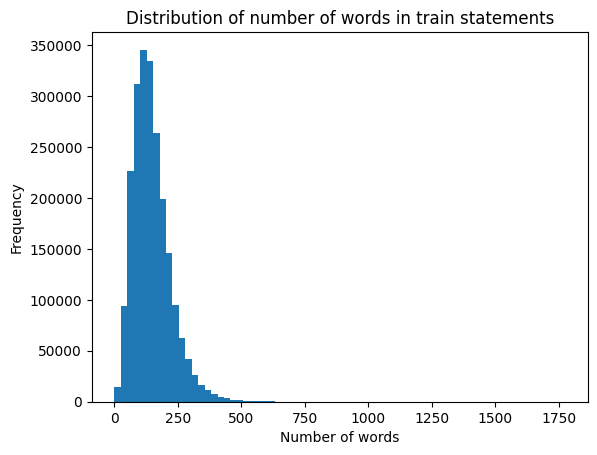

In [15]:
plt.hist(train_statments_words_count,bins=70)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of number of words in train statements')
plt.show()

In [ ]:
statment_length=int(np.percentile(train_statments_words_count,95))
statment_length

In [ ]:

vocab = set()
for statement in train_statments:
  for word in statement.split():
    vocab.add(word)

print(f"Number of unique words: {len(vocab)}")


In [18]:
vocabs_count= len(vocab)

In [ ]:
vocabs_count,statment_length

In [20]:
from tensorflow.keras.layers import TextVectorization ,Embedding

In [ ]:
text_vecto=TextVectorization(max_tokens=vocabs_count,
                             output_sequence_length=statment_length,

                             )

In [ ]:
len(train_statments)

In [ ]:
text_vecto.adapt(train_statments[:200000])


In [ ]:
text_embed=Embedding(vocabs_count,
                     statment_length,
                     mask_zero=True
                     )

In [ ]:
text_vecto.get_config()

In [ ]:
train_labels[:5]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_samples["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_samples["target"].to_numpy().reshape(-1, 1))


class_names = one_hot_encoder.categories_

In [ ]:
class_names

In [ ]:
train_line_number=train_samples['line_number']
test_line_number=test_samples['line_number']

train_line_number_one_hot=tf.one_hot(train_line_number.to_numpy(),depth=15)
test_line_number_one_hot=tf.one_hot(test_line_number.to_numpy(),depth=15)


In [ ]:
train_line_number_one_hot[0].shape

In [ ]:


train_data = tf.data.Dataset.from_tensor_slices(( train_statments,train_line_number_one_hot))
train_labels_tensor = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_full_data = tf.data.Dataset.zip((train_data, train_labels_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)



test_data = tf.data.Dataset.from_tensor_slices(( test_statments,test_line_number_one_hot))
test_labels_tensor = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_full_data = tf.data.Dataset.zip((test_data, test_labels_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
import tensorflow as tf

input_layer = tf.keras.layers.Input(shape=(1,), dtype='string', name="input_layer")
x = text_vecto(input_layer)
x = text_embed(x)
x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
output_layer = tf.keras.layers.Dense(64, activation='relu')(x)
model_1 = tf.keras.models.Model(input_layer, output_layer)

nd_input = tf.keras.layers.Input(shape=(15,))
nd_output = tf.keras.layers.Dense(32, activation='relu')(nd_input)
model_2 = tf.keras.models.Model(nd_input, nd_output)

flatten_layer = tf.keras.layers.Flatten()(model_1.output)

concatenated_output = tf.keras.layers.concatenate([flatten_layer, model_2.output])

final_output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(concatenated_output)

final_model = tf.keras.models.Model(inputs=[model_1.input, model_2.input], outputs=final_output_layer)


final_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = final_model.fit(train_full_data,steps_per_epoch=int(len(train_full_data)*0.2),epochs=2)


In [ ]:
final_model.summary()

In [ ]:
final_model.evaluate(test_full_data)

In [ ]:
actual_class

In [27]:

final_model = tf.keras.models.load_model('/content/drive/MyDrive/final_model')


In [ ]:
        import re
        import pandas as pd
        import tensorflow as tf
        class_names = ['BACKGROUND', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'OBJECTIVE']
        message = """Inhalational anthrax, a disease caused by inhaling Bacillus anthracis spores, leads to respiratory distress, vascular leakage, high-level bacteremia, and often death within days. Anthrax lethal toxin and edema toxin, which are composed of protective antigen (PA) plus either lethal factor (LF) or edema factor (EF), respectively, play an important yet incompletely defined role in the pulmonary pathophysiology. To better understand their contribution, we examined the structural integrity of the alveolar-capillary barrier in archival formalin-fixed lungs of cynomolgus monkeys challenged with the fully virulent B. anthracis Ames wild-type strain or the isogenic toxin-deficient mutants ΔEF, ΔLF, and ΔPA. Pulmonary spore challenge with the wild-type strain caused high mortality, intra-alveolar hemorrhages, extensive alveolar septal sequestration of bacteria and neutrophils, diffuse destabilization of epithelial and endothelial junctions, increased markers of coagulation and complement activation (including tissue factor and C5a), and multifocal intra-alveolar fibrin deposition. ΔEF challenge was lethal and showed similar alveolar-capillary alterations; however, intra-alveolar hemorrhages, bacterial deposition, and markers of coagulation or complement were absent or markedly lower. In contrast, ΔLF or ΔPA challenges were nonlethal and showed no signs of alveolar bacterial deposition or alveolar-capillary changes. These findings provide evidence that lethal toxin plays a determinative role in bacterial dissemination and alveolar-capillary barrier dysfunction, and edema toxin may significantly exacerbate pulmonary pathologies in a systemic infection."""
        sentences = re.split(r'(?<!\d\.\d)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', message)
        sentences_frame = pd.DataFrame(sentences, columns=['statement'])

        counter = 1
        for index, row in sentences_frame.iterrows():
            sentences_frame.at[index, 'line_number'] = counter
            counter += 1

        line_numbers = sentences_frame['line_number']
        sentences=sentences_frame['statement']

        preds = final_model.predict([sentences, tf.one_hot(line_numbers, depth=15)])

        actual_class = []
        for predss in preds:
            actual_class.append(class_names[predss.argmax()])

        sentences_frame['actual'] = actual_class

        BACKGROUND = ''
        METHODS = ''
        RESULTS = ''
        CONCLUSIONS = ''
        OBJECTIVE = ''

        for statement, _, actual in sentences_frame.itertuples(index=False):
            if actual == 'BACKGROUND':
                BACKGROUND += statement + '. '
            elif actual == 'METHODS':
                METHODS += statement + '. '
            elif actual == 'RESULTS':
                RESULTS += statement + '. '
            elif actual == 'CONCLUSIONS':
                CONCLUSIONS += statement + '. '
            elif actual == 'OBJECTIVE':
                OBJECTIVE += statement + '. '

        response = {
            'BACKGROUND': BACKGROUND,
            'METHODS': METHODS,
            'RESULTS': RESULTS,
            'CONCLUSIONS': CONCLUSIONS,
            'OBJECTIVE': OBJECTIVE
        }
        response